<a href="https://colab.research.google.com/github/SatioO/DL_Practices/blob/master/FCN_Using_Tensorflow_2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install -q git+https://github.com/tensorflow/examples.git
!pip install -q -U tfds-nightly

In [4]:
import tensorflow as tf
import os
import tensorflow.keras as keras

In [5]:
import tensorflow_datasets as tfds
from IPython.display import clear_output
import matplotlib.pyplot as plt

dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]
Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...:   0%|          | 0/1 [00:00<?, ? url/s]
Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...:   0%|          | 0/2 [00:00<?, ? url/s]
Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]Downloading and preparing dataset oxford_iiit_pet (801.24 MiB) to /Users/brain/tensorflow_datasets/oxford_iiit_pet/3.0.0...
Dl Size...:   0%|          | 0/755 [00:00<?, ? MiB/s]

Dl Size...:   0%|          | 0/773 [00:00<?, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]
Dl Size...:   0%|          | 1/773 [00:03<47:04,  3.66s/ MiB]

Extraction completed...: 0 file [00:03, ? file/s]
Dl Size...:   0%|          | 2/773 [00:04<35:33,  2.77s/ MiB]

Extraction completed...: 0 file [00:04, ? file/s]
Dl Size...:   0%|          | 3/773 [00:06<33:04,  2.58s/ MiB]

Extraction completed...: 0 file [00:06, ? file/s]
Dl Size...:   1%|          | 4/773 [00:07<28:41,  2.24s/ MiB]

Ext

KeyboardInterrupt: 

In [0]:
# !tar -xvf "/root/tensorflow_datasets/annotations.tar.gz"

images_path_dir = os.path.join("/root/tensorflow_datasets", "images")
annotations_path_dir = os.path.join("/root/tensorflow_datasets", "annotations")

train_list_file = os.path.join(annotations_path_dir, "trainval.txt")
test_list_file = os.path.join(annotations_path_dir, "test.txt")

OUTPUT_CHANNELS = 3
DROPOUT_RATE = 0.4

TRAIN_LENGTH = 3800
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

IMG_WIDTH = 128
IMG_HEIGHT = 128

In [0]:
def data_generator(file_path):
    with tf.io.gfile.GFile(file_path, "r") as images_list:
        for line in images_list:
            image_name, label, species, _ = line.strip().split(" ")

            trimaps_dir_path = os.path.join(annotations_path_dir, "trimaps")

            trimap_name = image_name + ".png"
            image_name += ".jpg"
            label = int(label) - 1
            species = int(species) - 1

            record = {
                "image": os.path.join(images_path_dir, image_name),
                "label": int(label),
                "species": species,
                "file_name": image_name,
                "segmentation_mask": os.path.join(trimaps_dir_path, trimap_name)
            }
            
            yield os.path.join(images_path_dir, image_name), os.path.join(trimaps_dir_path, trimap_name)

In [0]:
train_ds = tf.data.Dataset.from_generator(data_generator, output_types=(tf.string, tf.string), args=[train_list_file])
test_ds = tf.data.Dataset.from_generator(data_generator, output_types=(tf.string, tf.string), args=[test_list_file])

In [0]:
def normalize(input_image, input_mask):
    input_image = tf.image.per_image_standardization(input_image)
    input_mask -= 1
    return input_image, input_mask

def load_image(img_path, mask_path):
    input_image = tf.io.read_file(img_path)
    input_image = tf.image.decode_jpeg(input_image, channels = 3)
    input_image = tf.image.convert_image_dtype(input_image, tf.float32)
    input_image = tf.image.resize(input_image, (IMG_HEIGHT, IMG_WIDTH))
    
    input_mask = tf.io.read_file(mask_path)
    input_mask = tf.image.decode_png(input_mask, channels = 1)
    input_mask = tf.image.resize(input_mask, (IMG_HEIGHT, IMG_WIDTH))
    
    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask

train = train_ds.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = test_ds.map(load_image)

In [0]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [0]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

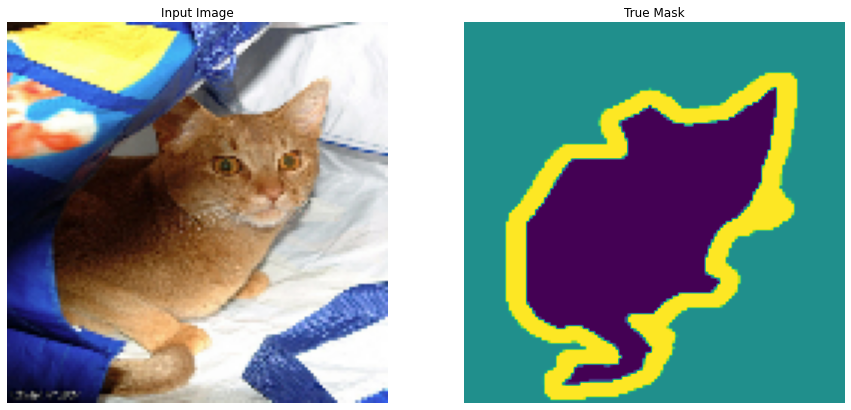

In [50]:
for image, mask in train.take(1):
  sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

In [0]:
def upsampling_layer(o, n_classes, kernel_size, drop_rate = 0.5):
  o = keras.layers.Conv2DTranspose(n_classes, kernel_size=kernel_size, strides=(2, 2), use_bias=False)(o)
  o = keras.layers.Cropping2D(((1, 1), (1, 1)))(o)
  return o

def build_fcn8_with_pretrained_vgg(input_shape, n_classes, drop_rate = 0.5):
  base_model = tf.keras.applications.VGG16(input_shape=input_shape, include_top=False)
  # Use the activations of these layers
  layer_names = [
      'block3_pool',   # 32x32 -> 16x16
      'block4_pool',   # 16x16 -> 8x8
      'block5_pool',   # 8x8 -> 4x4
  ]

  layers = [base_model.get_layer(name).output for name in layer_names]

  # Create the feature extraction model
  encoder = tf.keras.Model(inputs=base_model.input, outputs=layers)
  encoder.trainable = False

  inputs = keras.layers.Input(shape=input_shape)
  # Downsampling through the model
  x = inputs
  skips = encoder(x)

  o = keras.layers.Conv2D(4096, (7, 7), activation='relu', padding='same')(skips[-1])
  o = keras.layers.Dropout(drop_rate)(o)

  o = keras.layers.Conv2D(4096, (1, 1), activation='relu', padding='same')(o)
  o = keras.layers.Dropout(drop_rate)(o)

  o = keras.layers.Conv2D(n_classes, (1, 1), activation='relu')(o)

  # Upsampling and establishing the skip connections
  for skip in reversed(skips[:-1]):
    o = upsampling_layer(o, n_classes, (4, 4))
    o2 = keras.layers.Conv2D(n_classes, (1, 1), activation = 'relu')(skip)
    o = keras.layers.Add()([o2, o])

  # This is the last layer of the model
  o = keras.layers.Conv2DTranspose(n_classes, kernel_size=(16,16), strides=(8,8), use_bias=False)(o)
  o = keras.layers.Cropping2D(((4, 4), (4, 4)))(o)

  o = keras.layers.Softmax()(o)
  return keras.Model(inputs, o)

In [0]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [0]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [0]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

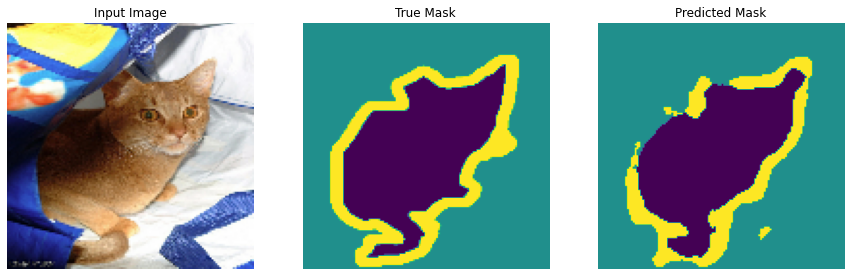


Sample Prediction after epoch 50

59/59 [==============================] - 13s 226ms/step - loss: 0.6283 - accuracy: 0.9127 - val_loss: 0.6929 - val_accuracy: 0.8451


In [55]:
EPOCHS = 50
VAL_SUBSPLITS = 5
VALIDATION_STEPS = 1000//BATCH_SIZE//VAL_SUBSPLITS

strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
  model = build_fcn8_with_pretrained_vgg((IMG_HEIGHT, IMG_WIDTH, 3), OUTPUT_CHANNELS)
  model.compile(optimizer='adam',
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

  model_history = model.fit(train_dataset, epochs=EPOCHS,
                            steps_per_epoch=STEPS_PER_EPOCH,
                            validation_steps=VALIDATION_STEPS,
                            validation_data=test_dataset,
                            callbacks=[DisplayCallback()])

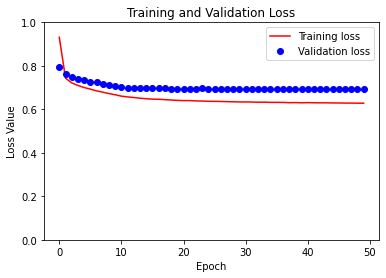

In [57]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

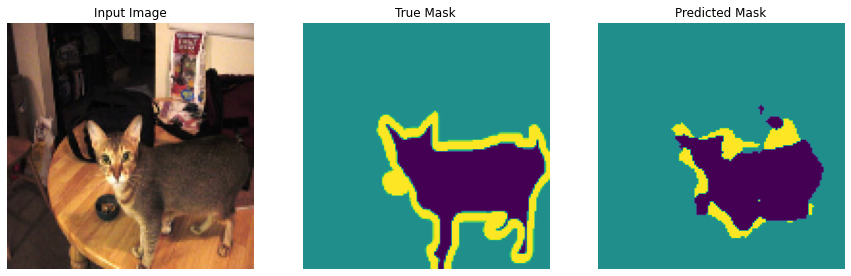

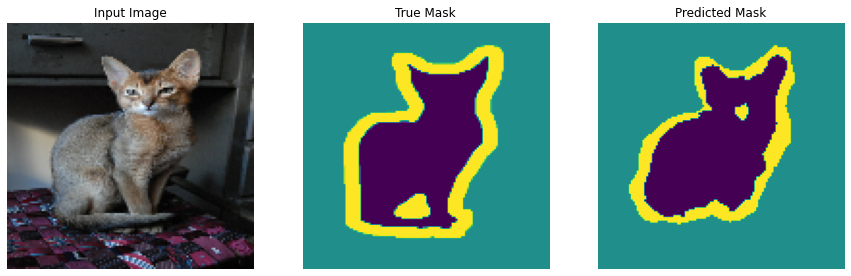

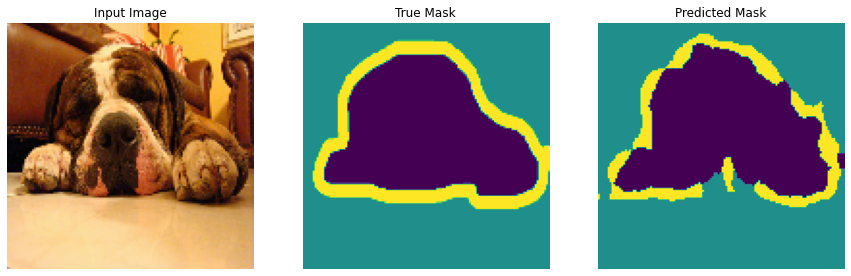

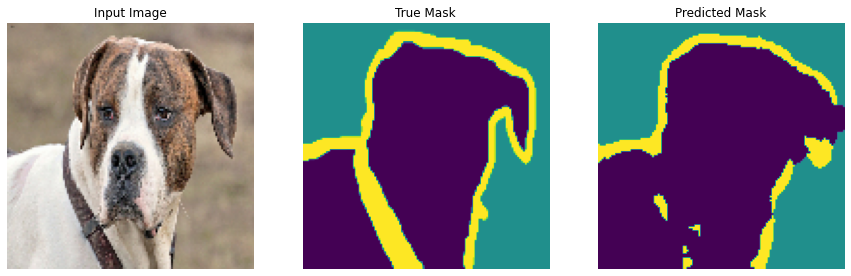

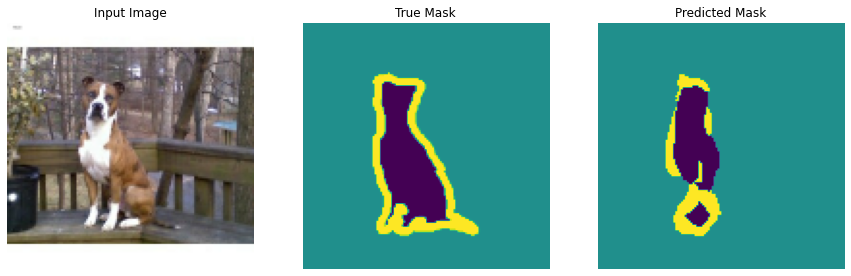

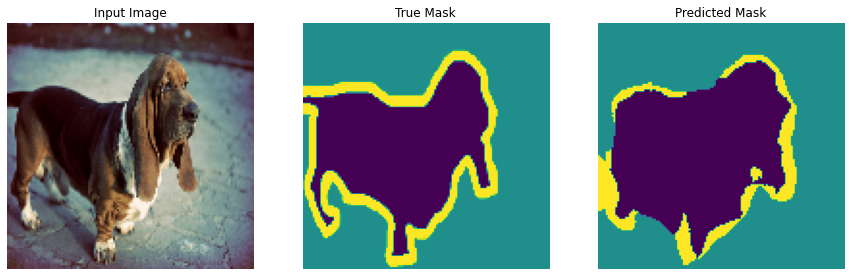

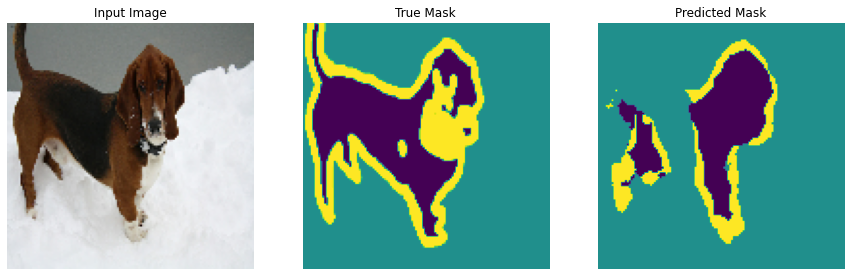

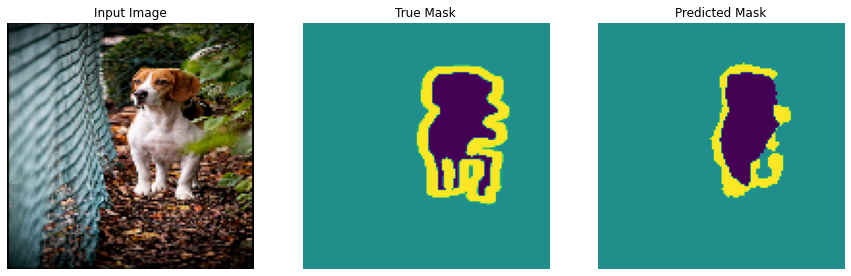

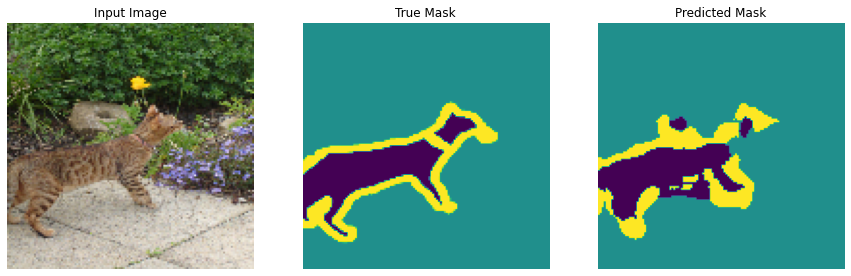

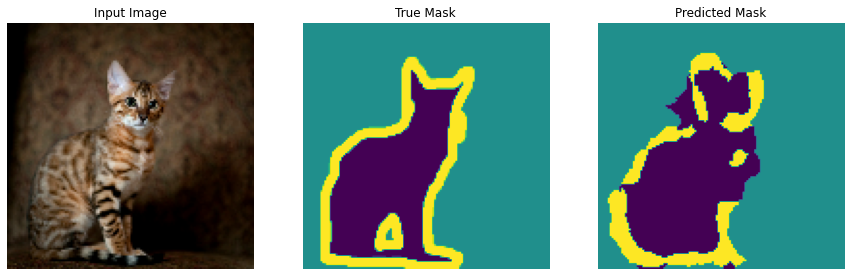

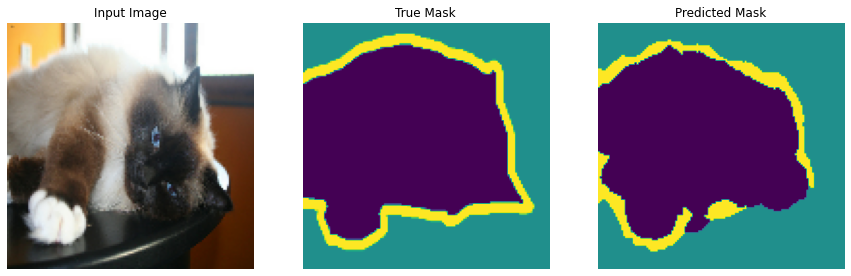

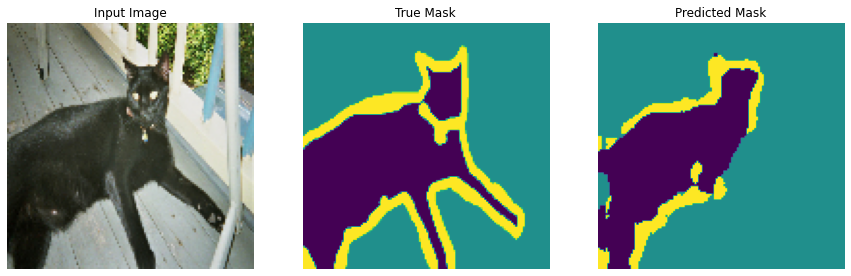

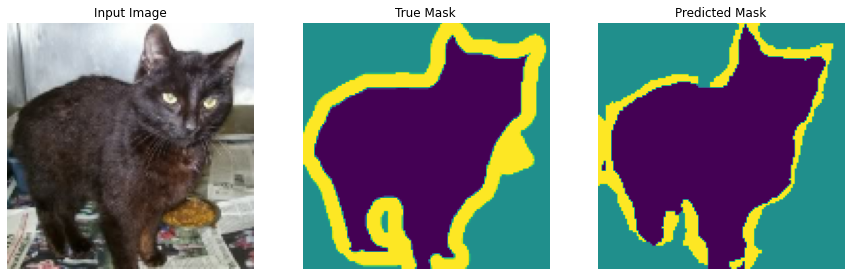

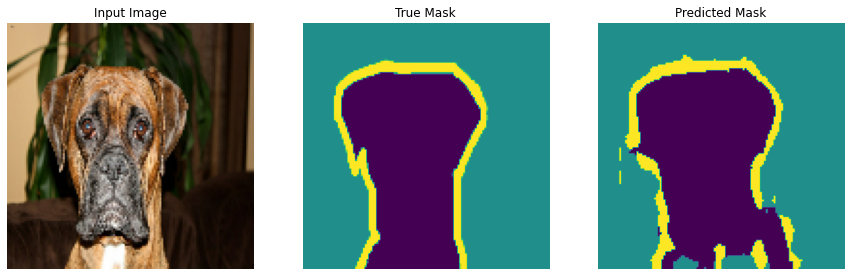

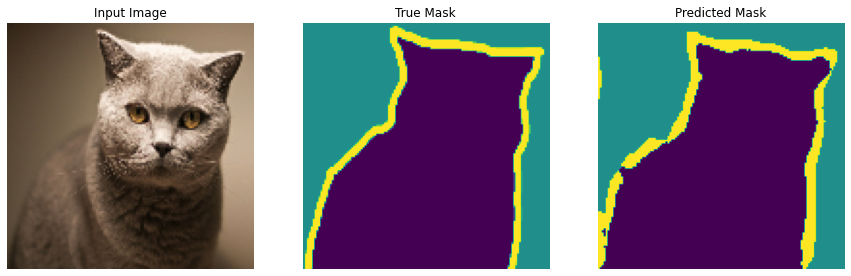

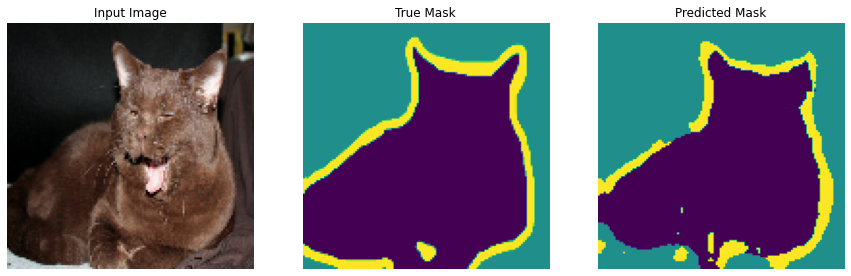

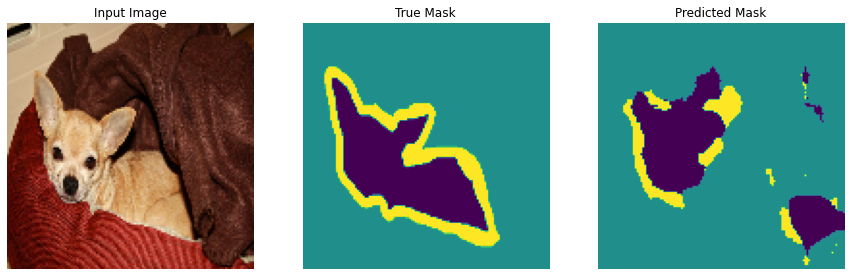

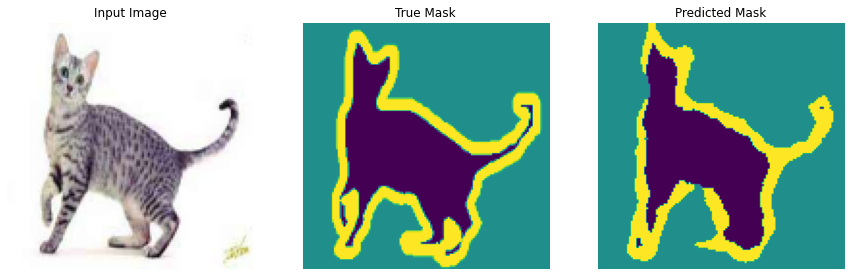

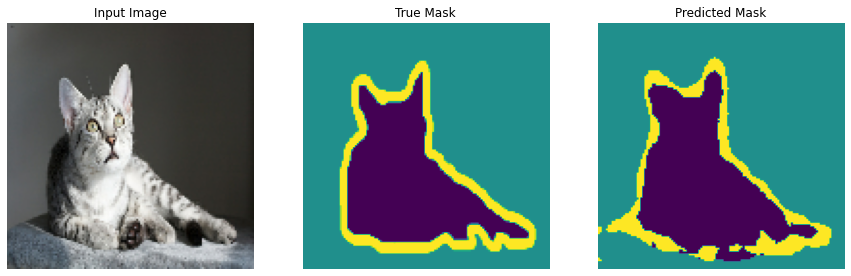

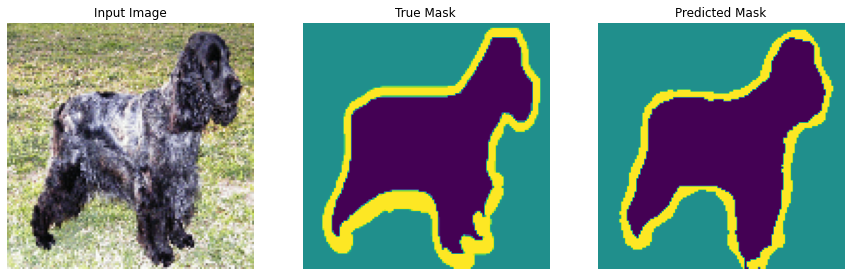

In [58]:
show_predictions(test_dataset, 20)